In [2]:
import pandas as pd
import numpy as np
import joblib
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/0930.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

load_path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/"

# /Users/bg.lim/Downloads/TAMU_Agri/New_CGM
path = "/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/df_alerts_raw.csv"
df_alerts_raw = pd.read_csv(path, low_memory=False)

# 1) 알림 메타정보
X_alerts = pd.read_csv(load_path + "1001alerts_with_X.csvX_alerts.csv")

# 2) SHAP 행렬 (raw positive-only)
shap_pos_clipped = np.load(load_path + "1001alerts_with_X.csv1001shap_pos_clipped.npy")

# 3) SHAP 행렬 (scaled)
X_scaled = np.load(load_path + "1001alerts_with_X.csv1001X_scaled.npy")

# 4) Feature 이름
FEATURES = joblib.load(load_path + "1001alerts_with_X.csvFEATURES.pkl")

# 확인
print("불러오기 완료!")
print("X_alerts shape:", X_alerts.shape)           
print("shap_pos_clipped shape:", shap_pos_clipped.shape)  
print("X_scaled shape:", X_scaled.shape)           
print("FEATURES 개수:", len(FEATURES))
print("예시 FEATURES:", FEATURES[:10])



불러오기 완료!
X_alerts shape: (634, 6)
shap_pos_clipped shape: (634, 79)
X_scaled shape: (634, 79)
FEATURES 개수: 79
예시 FEATURES: ['15m_G_Diff_5', '15m_G_Diff_6', '15m_G_Diff_7', '15m_G_Diff_8', '15m_G_Diff_9', '15m_G_Diff_10', 'Z_Previous_5', 'Z_Previous_6', 'Z_Previous_7', 'Z_Previous_8']


In [94]:
from scipy.cluster.hierarchy import fcluster
import pandas as pd

# 비교할 클러스터 개수 리스트
cluster_nums = [3, 4, 5, 6]

results = {}

for k in cluster_nums:
    clusters_k = fcluster(Z, t=k, criterion="maxclust")
    unique, counts = np.unique(clusters_k, return_counts=True)
    results[k] = dict(zip(unique, counts))

# 보기 좋게 DataFrame으로 변환
cluster_summary = pd.DataFrame(results).fillna(0).astype(int)
cluster_summary.index.name = "Cluster"
print(cluster_summary)


           3    4    5    6
Cluster                    
1         63   63   63   63
2        174  174  174  137
3        397   11   11   37
4          0  386  296   11
5          0    0   90  296
6          0    0    0   90


In [108]:
from scipy.cluster.hierarchy import fcluster

# k=5로 클러스터링
clusters_5 = fcluster(Z, t=5, criterion="maxclust")

# 메타데이터에 붙이기
X_with_cluster = X_alerts.copy()
X_with_cluster["Cluster"] = clusters_5

# 확인
unique, counts = np.unique(clusters_5, return_counts=True)
print("Cluster distribution:", dict(zip(unique, counts)))


Cluster distribution: {1: 63, 2: 174, 3: 11, 4: 296, 5: 90}


In [110]:
import numpy as np
import pandas as pd

# 제외할 클러스터
exclude_clusters = [3]

# 사용할 클러스터만 선택
target_clusters = [cl for cl in np.unique(X_with_cluster["Cluster"]) if cl not in exclude_clusters]

cluster_centers = {}
central_indices = {}

for cl in target_clusters:
    idxs = np.where(X_with_cluster["Cluster"] == cl)[0]
    cluster_data = X_scaled[idxs]

    # Mean center
    center = cluster_data.mean(axis=0)
    cluster_centers[cl] = center

    # Top 5 samples closest to center
    dists = np.linalg.norm(cluster_data - center, axis=1)
    closest_idx = idxs[np.argsort(dists)[:5]]
    central_indices[cl] = closest_idx

print("Central indices (closest 5 samples per cluster):")
for cl, idxs in central_indices.items():
    print(f"Cluster {cl}: {idxs.tolist()}")


Central indices (closest 5 samples per cluster):
Cluster 1: [578, 241, 497, 105, 569]
Cluster 2: [83, 534, 426, 531, 138]
Cluster 4: [629, 316, 441, 628, 352]
Cluster 5: [161, 374, 146, 419, 252]


In [112]:
import numpy as np
import pandas as pd

cluster_shap_mean = {}
for clust in np.unique(X_with_cluster["Cluster"]):
    if clust in [1,2,4,5]:  # 3 제외
        idx = X_with_cluster["Cluster"] == clust
        cluster_shap_mean[clust] = np.abs(shap_pos_clipped[idx]).mean(axis=0)

top_feats = {}
for clust, shap_vals in cluster_shap_mean.items():
    top_idx = np.argsort(shap_vals)[::-1][:5]
    top_feats[clust] = [FEATURES[i] for i in top_idx]

# 보기 좋게 DataFrame으로 정리
top_feats_df = pd.DataFrame.from_dict(top_feats, orient="index", columns=[f"Top{i+1}" for i in range(5)])
top_feats_df


,Top1,Top2,Top3,Top4,Top5
1,hungry,mean_intensity_1h,hungry_within,Time_24h,How_tired
2,Z_Previous_4,Time_24h,mean_intensity_1h,G_minus_T_pre_1.5h,How_anxious_within
4,mean_intensity_1h,Time_24h,hungry,hungry_within,EMA_T_Diff
5,Time_24h,mean_intensity_1h,15m_G_Diff_6,Efficiency,15m_G_Diff_5



=== Cluster 4 representative samples ===
Sample index: 629


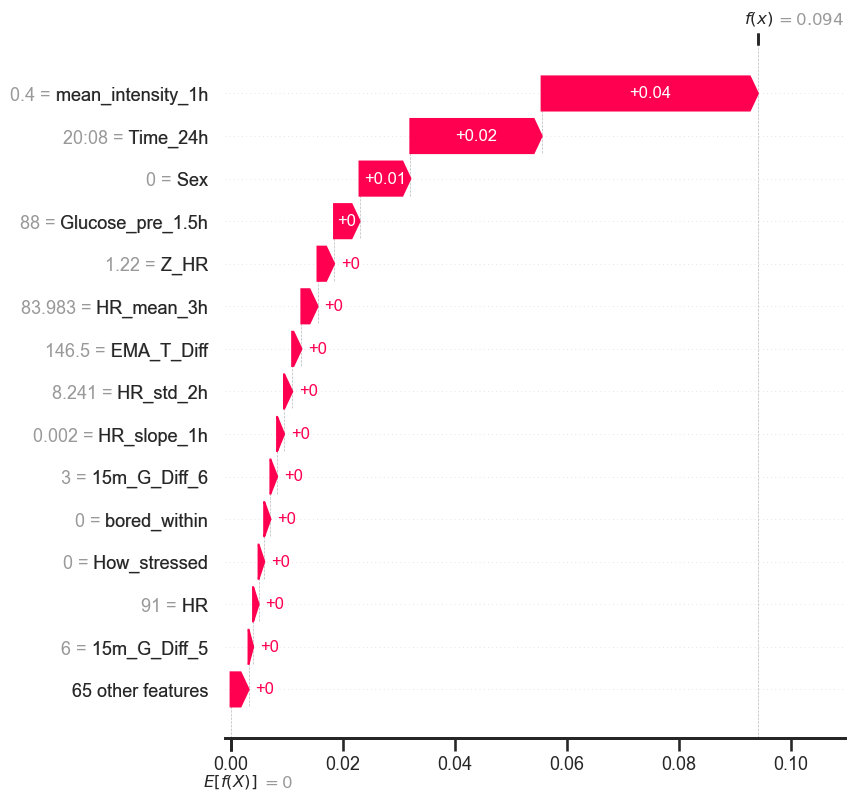

Sample index: 316


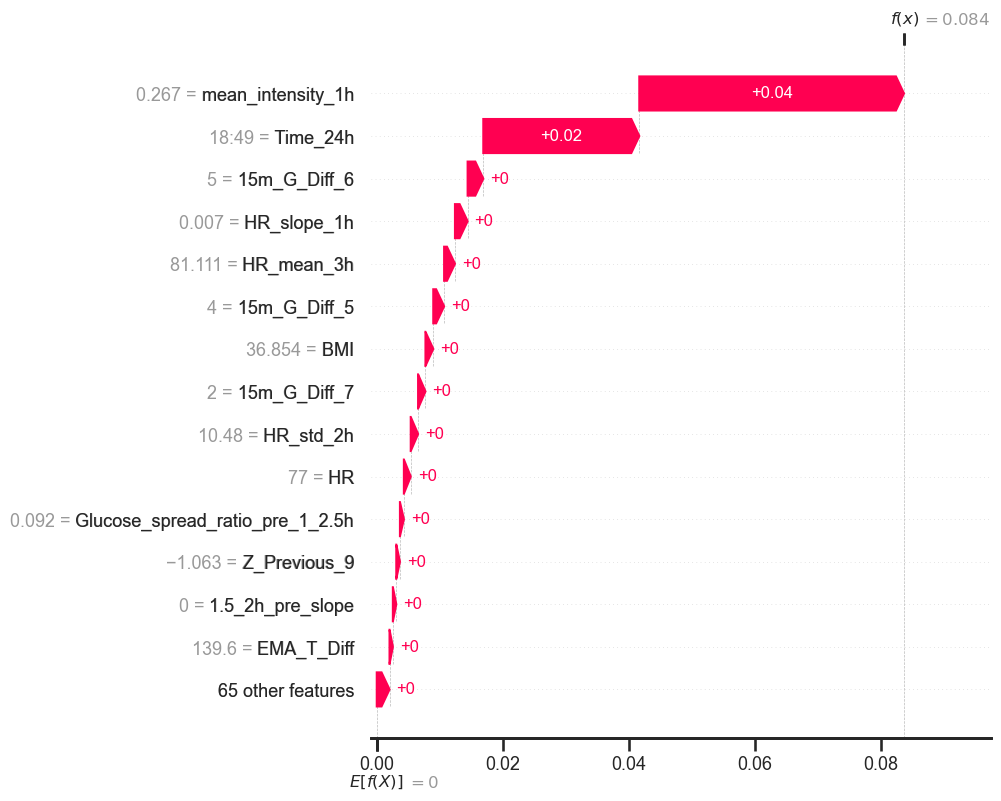

Sample index: 441


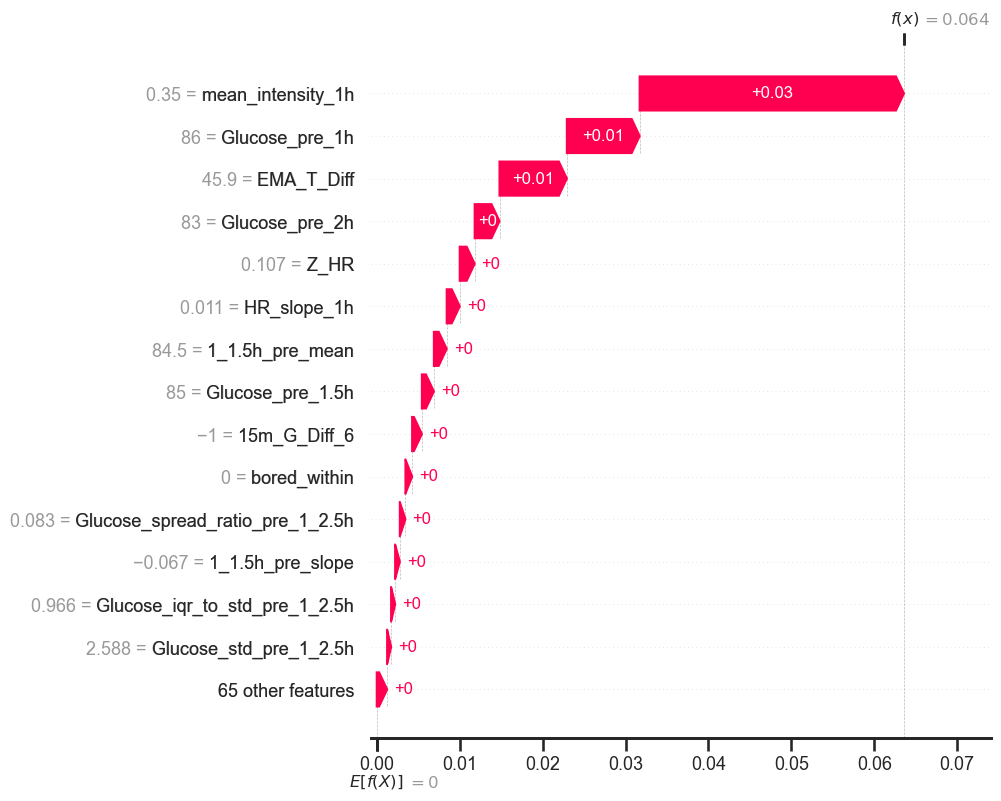

Sample index: 628


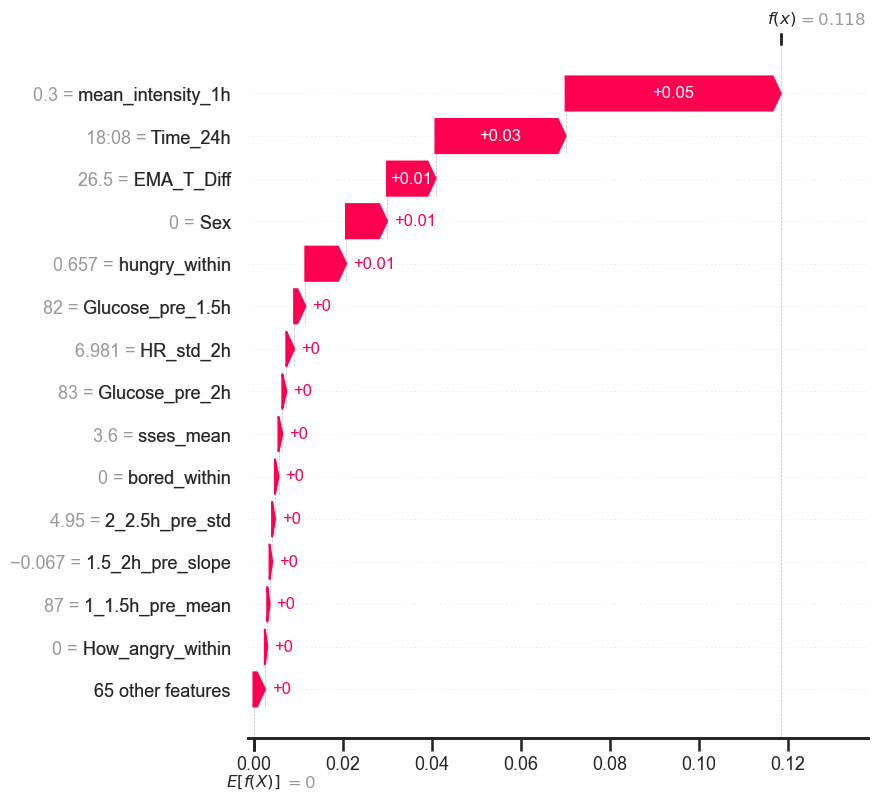

Sample index: 352


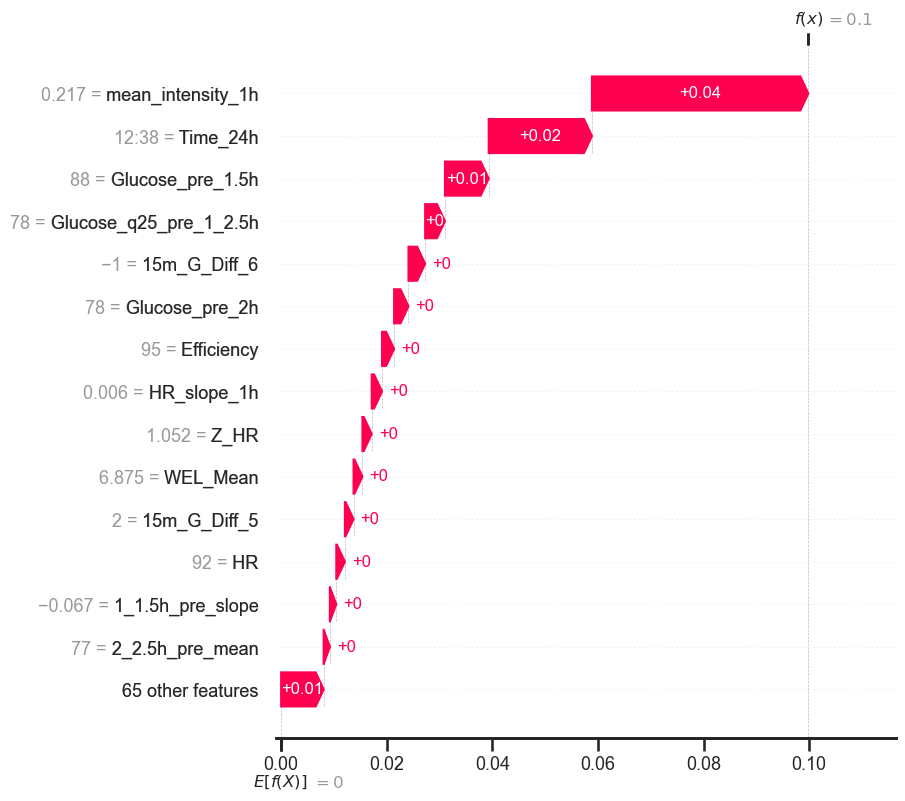


=== Cluster 5 representative samples ===
Sample index: 161


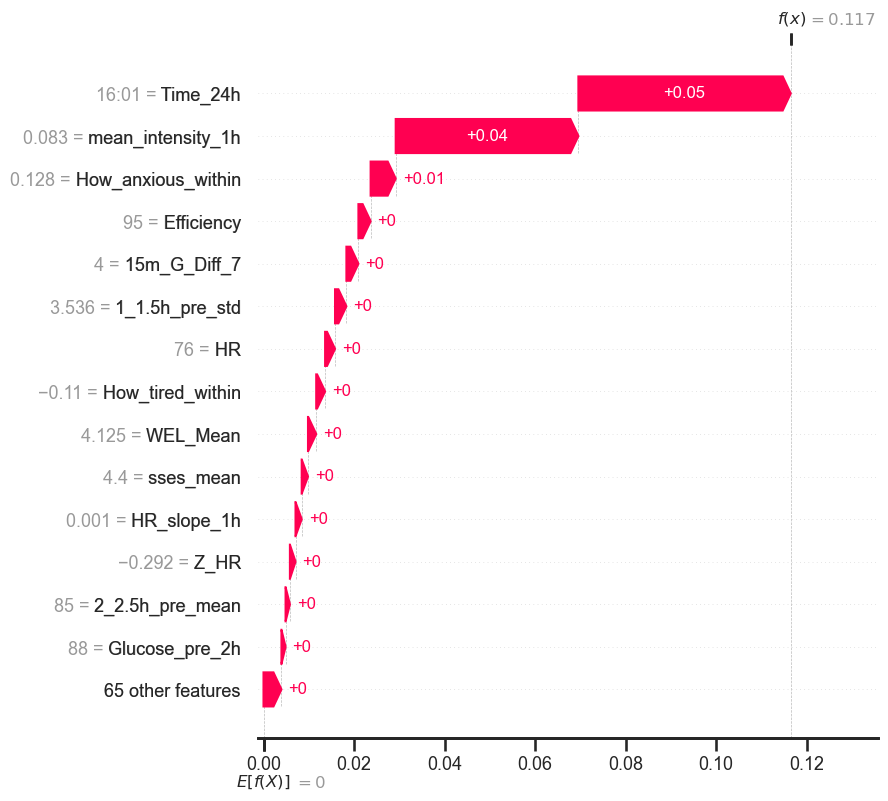

Sample index: 374


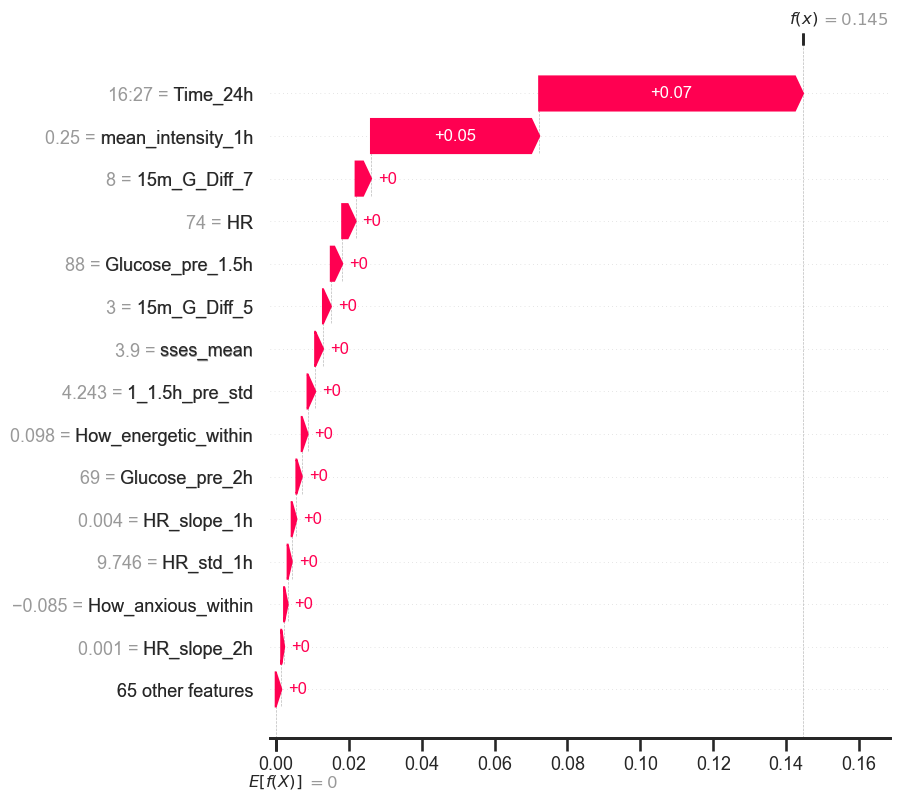

Sample index: 146


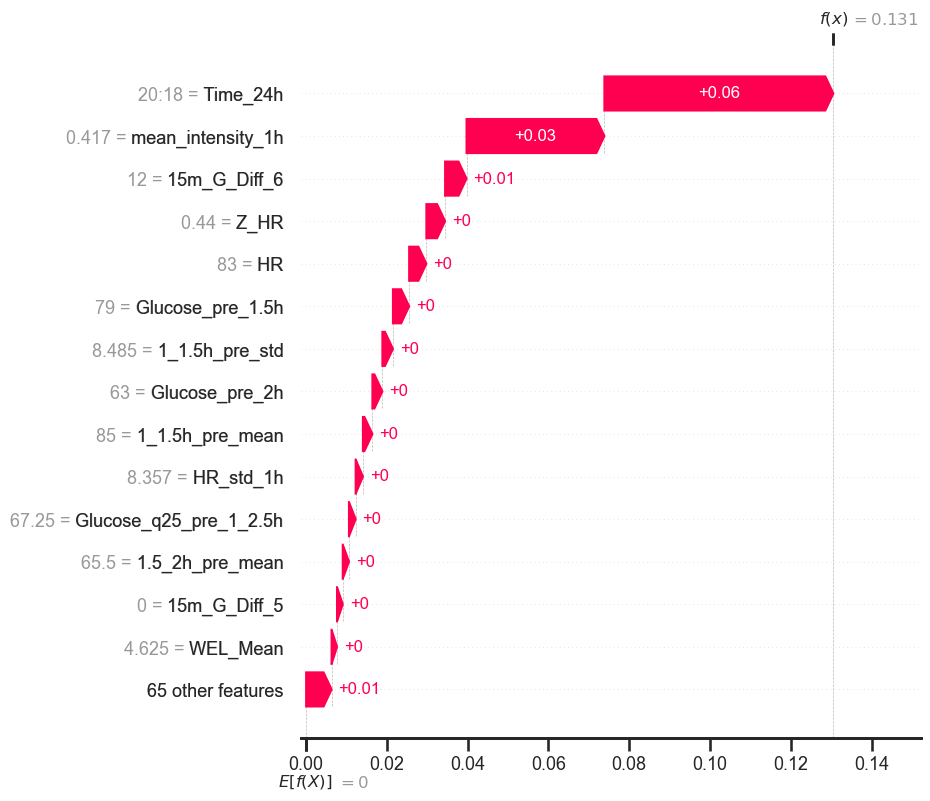

Sample index: 419


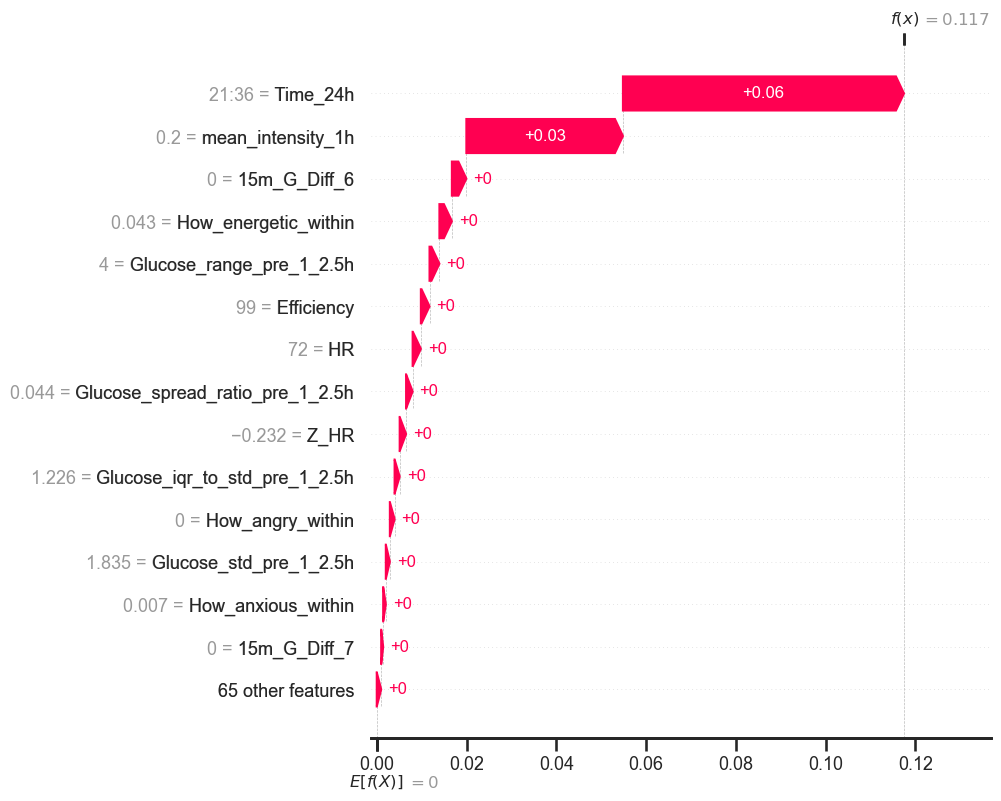

Sample index: 252


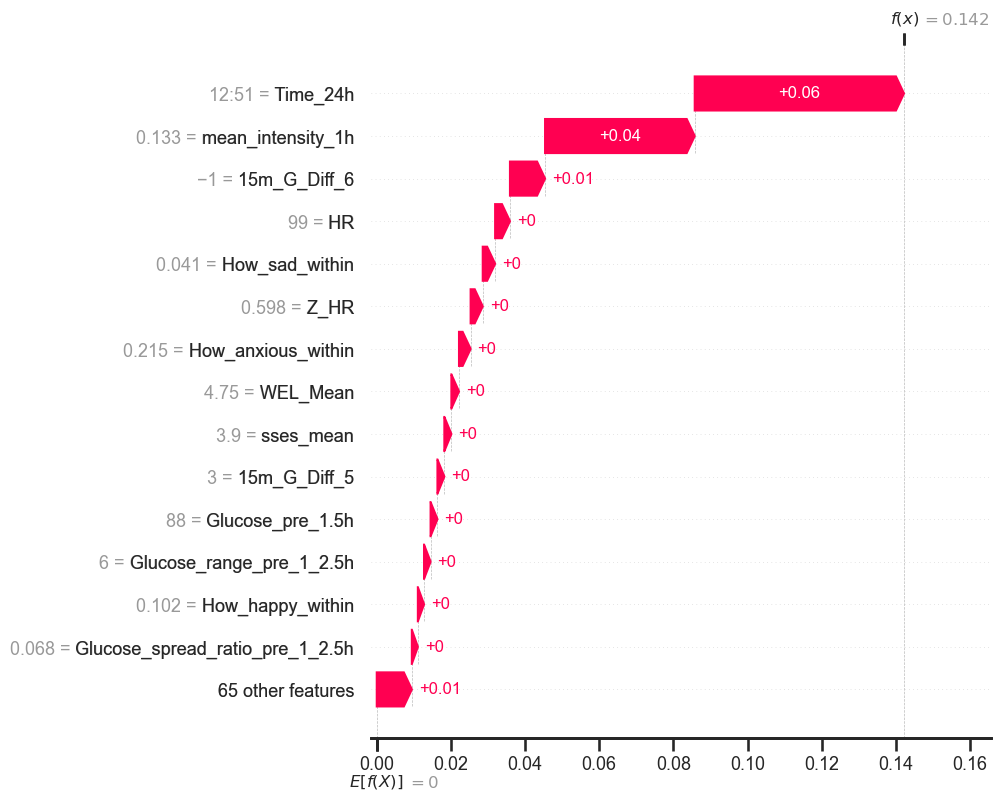

In [118]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# feature matrix DataFrame
X_features = pd.DataFrame(df_alerts_raw, columns=FEATURES)

# 시각화 대상 클러스터
target_clusters = [4, 5]

for cl in target_clusters:
    print(f"\n=== Cluster {cl} representative samples ===")
    for i in central_indices[cl]:
        print(f"Sample index: {i}")
        
        shap_values_sample = shap_pos_clipped[i]
        feature_values = X_features.iloc[i].values

        expl = shap.Explanation(
            values=shap_values_sample,
            base_values=0,
            data=feature_values,
            feature_names=FEATURES
        )

        shap.plots.waterfall(expl, max_display=15, show=True)
        plt.show()
